In [30]:
# data prepraration: git clone, data augmentation
!nvidia-smi

Thu Jun 13 15:29:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              30W /  70W |   8317MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [31]:
!git clone https://github.com/cbtn-data-science-ml/ml_datasets.git

Cloning into 'ml_datasets'...
remote: Enumerating objects: 38084, done.
remote: Counting objects: 100% (13080/13080), done.
remote: Compressing objects: 100% (13075/13075), done.
remote: Total 38084 (delta 8), reused 13064 (delta 0), pack-reused 25004
Receiving objects: 100% (38084/38084), 1.14 GiB | 41.82 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (39805/39805), done.


In [32]:
%pwd

'/content/ml_datasets'

In [33]:
import os
os.chdir('ml_datasets')

In [34]:
%pwd

'/content/ml_datasets/ml_datasets'

In [35]:
%ls

cats_vs_dogs/  model_utils.py  README.md         waffles_or_nachos/
food_10/       ramen_sushi/    reduced_dataset/


In [36]:
dataset_path = "/content/ml_datasets/reduced_dataset"

In [37]:
from keras.preprocessing.image import ImageDataGenerator

In [38]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [57]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SHAPE,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'food_10/test',
    target_size=IMAGE_SHAPE,
    batch_size=32,
    class_mode='categorical'
)

Found 800 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [58]:
!wget https://raw.githubusercontent.com/cbtn-data-science-ml/ml_datasets/main/model_utils.py

--2024-06-13 15:38:45--  https://raw.githubusercontent.com/cbtn-data-science-ml/ml_datasets/main/model_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2299 (2.2K) [text/plain]
Saving to: ‘model_utils.py.2’

model_utils.py.2    100%[===================>]   2.25K  --.-KB/s    in 0s      

2024-06-13 15:38:45 (28.4 MB/s) - ‘model_utils.py.2’ saved [2299/2299]



In [41]:
from model_utils import create_model_from_kaggle_tfhub, plot_loss_and_accuracy, MyCallback, early_stopping_callback, model_checkpoint_callback

In [59]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense

In [60]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False # Freeze base model


In [61]:
model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [62]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [63]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
25/25 [==============================] - 23s 778ms/step - loss: 5.2364 - accuracy: 0.1100 - val_loss: 3.2511 - val_accuracy: 0.1145
Epoch 2/10
25/25 [==============================] - 18s 739ms/step - loss: 2.7007 - accuracy: 0.1388 - val_loss: 2.4092 - val_accuracy: 0.2010
Epoch 3/10
25/25 [==============================] - 37s 1s/step - loss: 2.3724 - accuracy: 0.1500 - val_loss: 2.2864 - val_accuracy: 0.1550
Epoch 4/10
25/25 [==============================] - 36s 1s/step - loss: 2.3919 - accuracy: 0.1538 - val_loss: 2.2678 - val_accuracy: 0.1970
Epoch 5/10
25/25 [==============================] - 37s 2s/step - loss: 2.4153 - accuracy: 0.1538 - val_loss: 2.1873 - val_accuracy: 0.1865
Epoch 6/10
25/25 [==============================] - 18s 739ms/step - loss: 2.2318 - accuracy: 0.1863 - val_loss: 2.3170 - val_accuracy: 0.1960
Epoch 7/10
25/25 [==============================] - 19s 755ms/step - loss: 2.2809 - accuracy: 0.1787 - val_loss: 2.3305 - val_accuracy: 0.1865
Epoch 8/

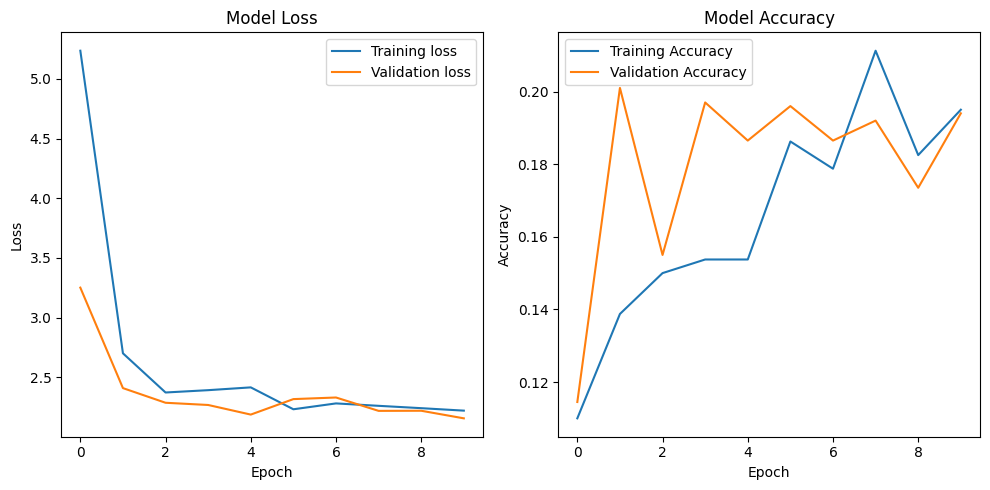

In [64]:
plot_loss_and_accuracy(history)

In [65]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) -10

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [66]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

In [67]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [68]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [69]:
len(base_model.layers)

175

In [70]:
len(base_model.layers) - 10

165

In [71]:
history_fine_tuning = model.fit(
    train_generator,
    epochs=20,
    validation_data = test_generator,
    callbacks=[model_checkpoint_callback],
    verbose=1
)

Epoch 1/20
25/25 [==============================] - 25s 745ms/step - loss: 2.6458 - accuracy: 0.1838 - val_loss: 2.2549 - val_accuracy: 0.1595
Epoch 2/20
25/25 [==============================] - 22s 889ms/step - loss: 2.2559 - accuracy: 0.1925 - val_loss: 2.2262 - val_accuracy: 0.1660
Epoch 3/20
25/25 [==============================] - 18s 740ms/step - loss: 2.1492 - accuracy: 0.2362 - val_loss: 2.2245 - val_accuracy: 0.1745
Epoch 4/20
25/25 [==============================] - 19s 758ms/step - loss: 2.1742 - accuracy: 0.2325 - val_loss: 2.2458 - val_accuracy: 0.1760
Epoch 5/20
25/25 [==============================] - 18s 740ms/step - loss: 2.1161 - accuracy: 0.2525 - val_loss: 2.2941 - val_accuracy: 0.1210
Epoch 6/20
25/25 [==============================] - 22s 896ms/step - loss: 2.0521 - accuracy: 0.2450 - val_loss: 2.2763 - val_accuracy: 0.1555
Epoch 7/20
25/25 [==============================] - 18s 739ms/step - loss: 2.0450 - accuracy: 0.2550 - val_loss: 2.3740 - val_accuracy: 0.1600

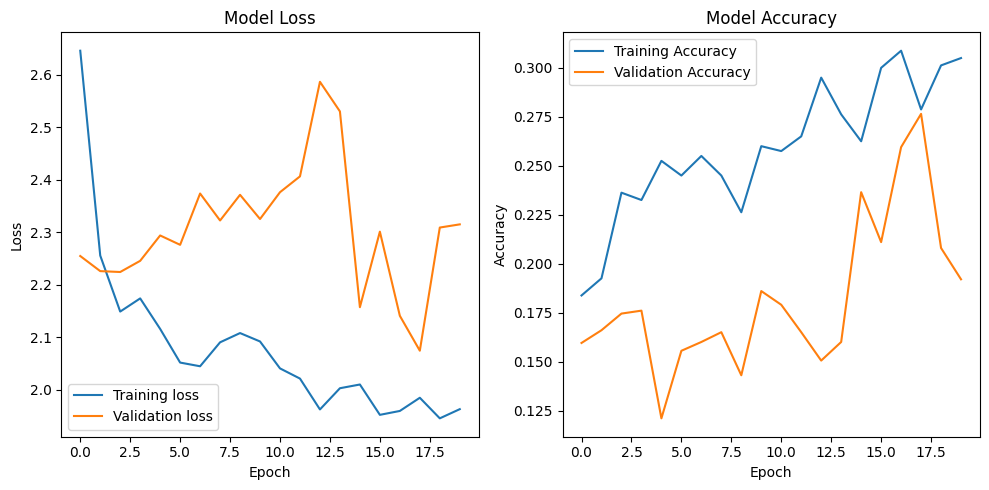

In [72]:
plot_loss_and_accuracy(history_fine_tuning)